## Set up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.tree import plot_tree

In [2]:
# load summary metrics file
summary_df = pd.read_csv('../data/derived/performance/summary.csv')

# preview dataframe
summary_df.sample(5)

,model_name,dataset_name,vector_name,hyperparameter_name,hyperparameter_value,metric_name,metric_value
1741,mlp,train,count,alpha,0.0001,macro_recall,1.000000
812,decisiontree,train,lsi10,maxdepth,None,true_positives,2684.000000
351,decisiontree,dev,lsi50,maxdepth,50,false_positives,210.000000
1117,mlp,train,count,alpha,1,binary_recall,0.973929
1739,mlp,train,count,alpha,0.0001,false_negatives,0.000000


## Visualize decision tree

In [3]:
def get_vocab_list(vocabulary):
    """
    Convert count vectorizer vocabulary dictionary into ordered list
    """
    # initialize empty list of same length as vocabulary
    vocab_list = [None] * len(vocabulary)

    # iterate over items in count vectorizer's dictionary
    for token, index in vocabulary.items():
        # save token at corresponding index in vocabulary list
        vocab_list[index] = token
        
    return vocab_list

In [4]:
def plot_decision_tree():
    """
    Plot first two branches of smallest decision tree with count vectors for interpretability
    """
    # import decision tree model
    tree = pickle.load(open('../data/derived/models/decisiontree_vectorcount_maxdepth10.pkl', 'rb' ))

    # import bag of words transformer
    count_vectorizer = pickle.load(open('../data/derived/models/vectorizer_count.pkl', 'rb'))

    # get vocabulary as ordered list
    vocab_list = get_vocab_list(count_vectorizer.vocabulary_)
    
    # plot decision tree
    plt.figure(figsize=(15,9))
    plot_tree(tree, fontsize=12, max_depth=2, feature_names=vocab_list, rounded=True, 
              class_names=['not sexist', 'sexist'])
    
    # save and show figure
    plt.savefig('../data/derived/visualizations/decisiontree_branches.png', format='png')
    plt.show()
    
    return None

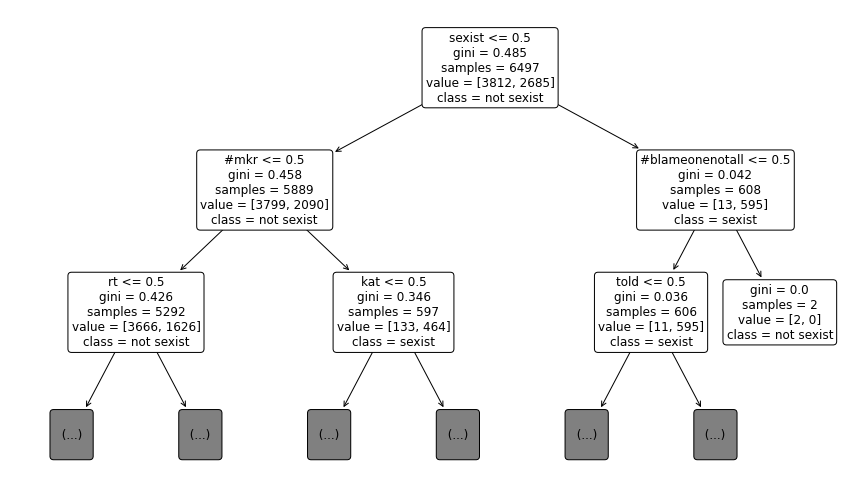

In [5]:
plot_decision_tree()

## Visualize performance with line plots

In [6]:
def plot_performance(metric_name,
                     row_order_list = ['count','tfidf','lsi100','lsi50','lsi10','lsi5'],
                     col_order_list = ['decisiontree', 'svc', 'mlp']):
    
    #---------
    # prepare data
    
    # copy summary dataframe
    df = summary_df.copy()

    # filter dataframe to provided metric
    df = df[df['metric_name'] == metric_name]

    # sort dataframe by ascending hyperparameter value
    sorted_idx = np.argsort([float(x) if x.replace('.','',1).isnumeric() else float('inf') for x in df['hyperparameter_value']])
    df = df.iloc[sorted_idx, :]
    
    #---------
    # get metric title from metric name (used in y-axis label)
    if 'f1' in metric_name:
        metric_title = 'F1 score'
    elif 'recall' in metric_name:
        metric_title = 'Recall'
    elif 'precision' in metric_name:
        metric_title = 'Precision'
    else:
        metric_title = metric_name
        
    #---------
    # create plot
    
    # set style
    sns.set_style("whitegrid")

    # initialize facet grid
    g = sns.FacetGrid(df,
                      hue = 'dataset_name', 
                      row = 'vector_name',
                      row_order = row_order_list,
                      col='model_name',
                      col_order = col_order_list,
                      size = 2, aspect = 1.5)

    # add scatter plot
    g = g.map(plt.scatter, 'hyperparameter_value', 'metric_value')
    
    # add line plot
    g = g.map(plt.plot, 'hyperparameter_value', 'metric_value')

    # add y-axis labels
    for row in range(len(row_order_list)):
        # add titles to rows
        g.axes[row, 0].set_ylabel(f'{row_order_list[row]}\n{metric_title}')
        for col in range(len(col_order_list)):
            # add titles to columns
            g.axes[0, col].set_title(f'{col_order_list[col]}')
            # remove titles from columns past first row
            if row != 0:
                g.axes[row, col].set_title('')

    # adjust tick labels (because hyperparameter values differ by model)
    g.set_xticklabels(['a','b','c','d'])
    
    # save figure
    g.tight_layout()
    g.add_legend()
    g.savefig(f'../data/derived/visualizations/performance_{metric_name}.png')
    
    return None

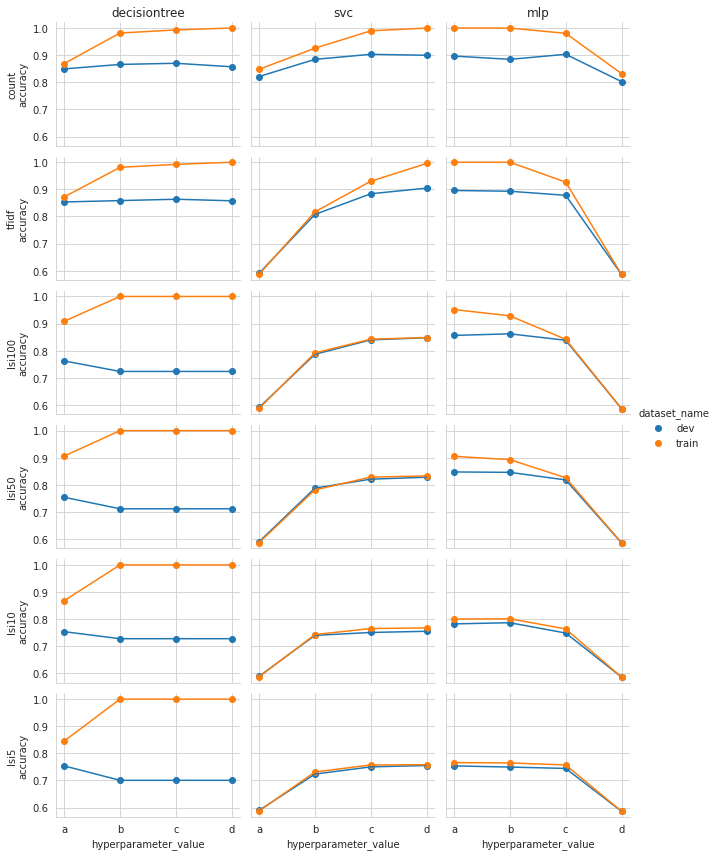

In [7]:
plot_performance('accuracy')

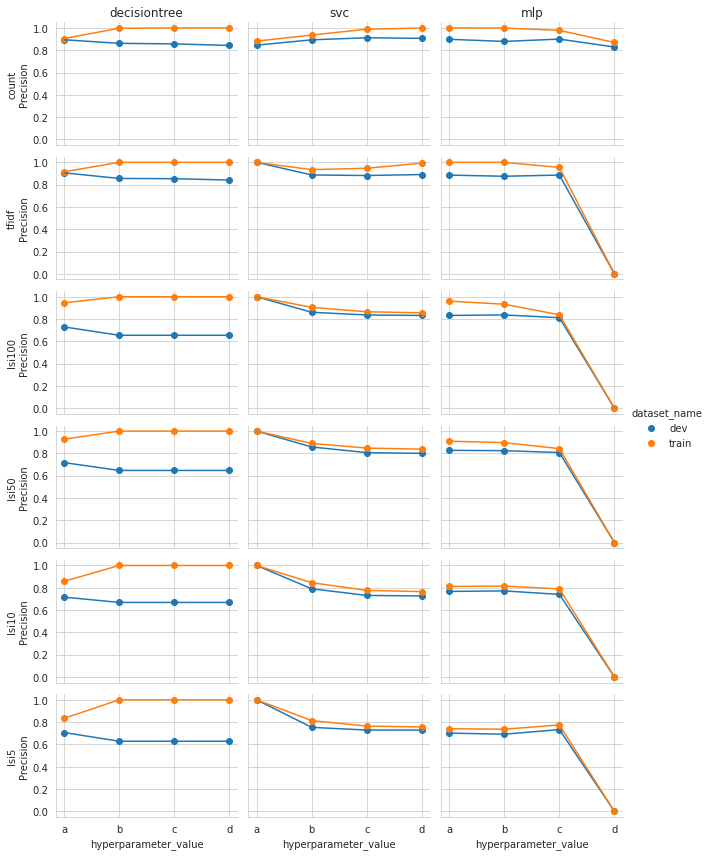

In [8]:
plot_performance('binary_precision')

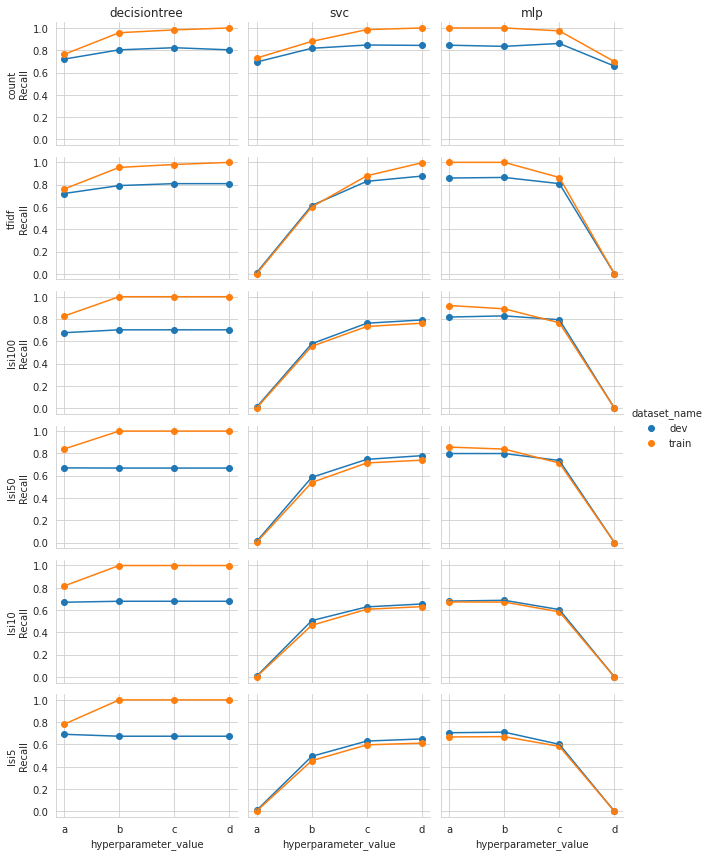

In [9]:
plot_performance('binary_recall')

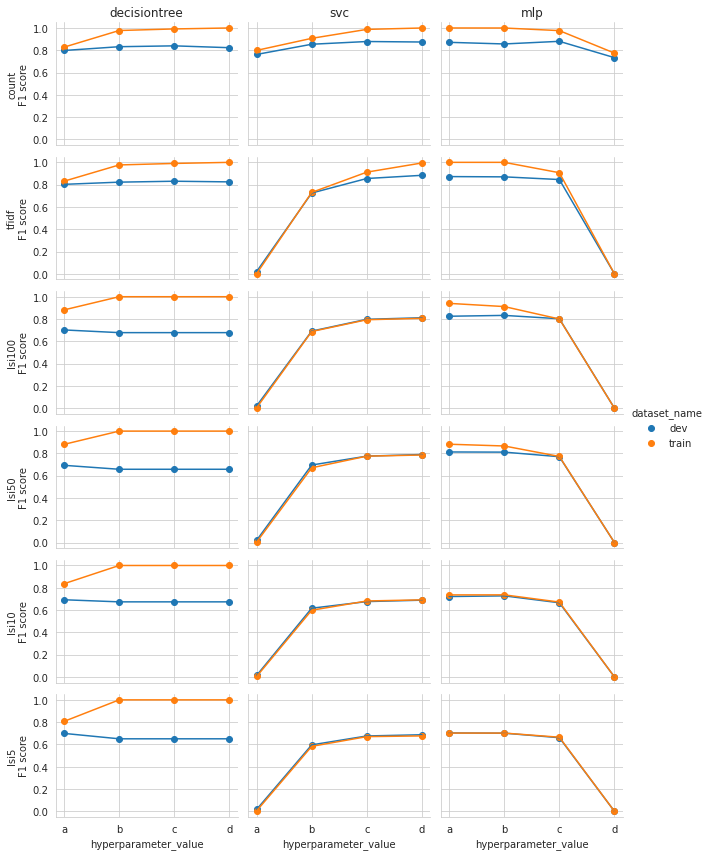

In [10]:
plot_performance('binary_f1')